### Import Packages

In [2]:
import matplotlib.image as mpimg # 0 to 1
import matplotlib.pyplot as plt
import numpy as np
import cv2 # 0 to 255
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label

### Define Functions

In [3]:
# Define a function to return HOG features and visualization
def convert_color(img, conv='RGB2YCrCb'): # (0, 255)
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True): 
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)): # (0, 255)
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)): # (0, 255)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.hstack((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), # (0, 255)
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):   
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)   
    #3) Compute spacial features if flag is set
    if spatial_feat == True:
        spactial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spactial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows 

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    window_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)  )    
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                window_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart), (0,0,255), 6) 
            else: pass
            
    return draw_img, window_list

# Multiple Detections & False Positives
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0 
    return heatmap

def draw_labeled_bboxes(img, labels):
    '''
    from scipy.ndimage.measurements import label
    labels = label(heatmap)
    '''
    bbox_list = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        if abs(bbox[1][1] - bbox[0][1]) <= abs(bbox[1][0] - bbox[0][0]):
            if abs(bbox[1][1] - bbox[0][1]) < 40 or abs(bbox[1][0] - bbox[0][0]) < 40: # set at 80
                pass
            else:
                cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6) 
                bbox_list.append(bbox)
        else: pass
        
        ## The width of a car should be larger than its height
        #if abs(bbox[1][1] - bbox[0][1]) <= abs(bbox[1][0] - bbox[0][0]):
        #    if abs(bbox[1][1] - bbox[0][1]) < 40:
        #        # Do nothing
        #        pass
        #    elif abs(bbox[1][0] - bbox[0][0]) < 40:
        #        pass
        #    elif abs(bbox[1][1] - bbox[0][1]) >= 40 & abs(bbox[1][0] - bbox[0][0]) >= 40:
        #        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6) 
        #        bbox_list.extend(bbox)
        #else: pass
    # Return the image
    
    return img, bbox_list

def multiple_window_search(image, x_start_stop, y_start_stop):
    '''
    import slide_window, search_windows, draw_boxes
    '''
    window_sizes = np.arange(96, y_start_stop[1]-y_start_stop[0]-32, 32)
    
    draw_image = np.copy(image)
    
    all_windows = []
    for sz in window_sizes:
    
        windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                               xy_window=(sz, sz), xy_overlap=(0.75, 0.75))

        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                     spatial_size=spatial_size, hist_bins=hist_bins, 
                                     orient=orient, pix_per_cell=pix_per_cell, 
                                     cell_per_block=cell_per_block, 
                                     hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                     hist_feat=hist_feat, hog_feat=hog_feat) 
        
        draw_image = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
        
        all_windows.extend(hot_windows)
  
    return draw_image, all_windows   

/Library/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


color space=YCrCb, orient=8, pix per cell=16, cell per block=2


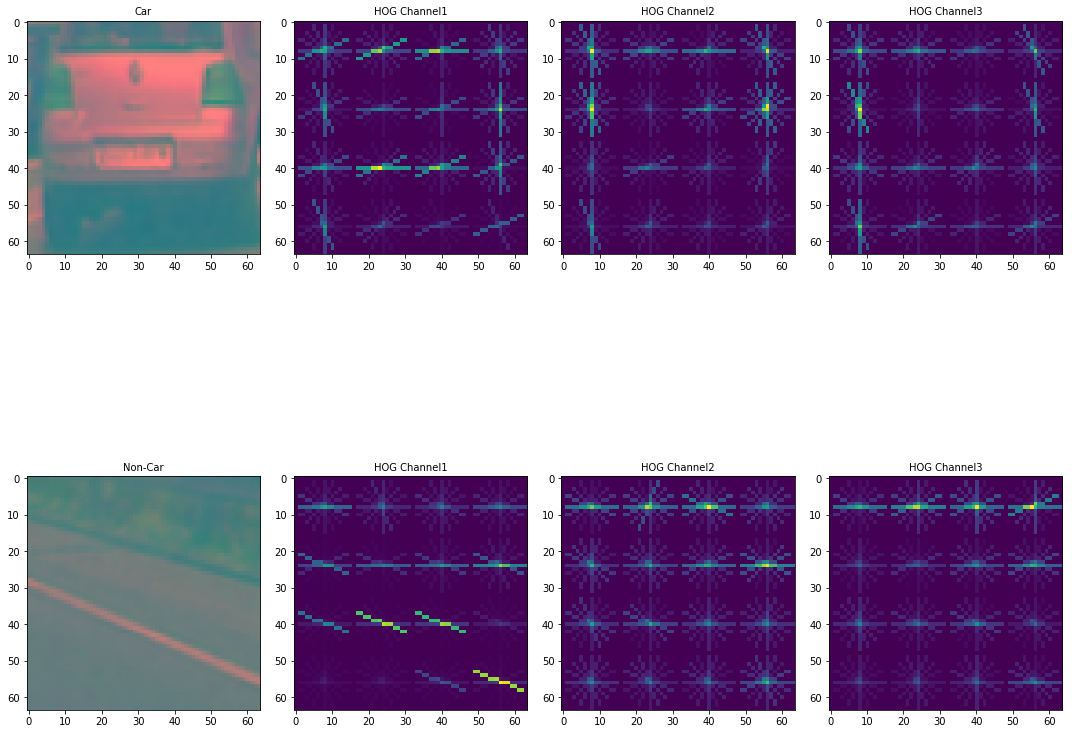

In [10]:
car_image = mpimg.imread('test_images/car.png')
noncar_image = mpimg.imread('test_images/road.png')
car_image = convert_color(car_image)
noncar_image = convert_color(noncar_image)
_, car_hog_c1 = get_hog_features(car_image[:,:,0], orient=8, pix_per_cell=16, cell_per_block=2, vis=True, feature_vec=True)
_, car_hog_c2 = get_hog_features(car_image[:,:,1], orient=8, pix_per_cell=16, cell_per_block=2, vis=True, feature_vec=True)
_, car_hog_c3 = get_hog_features(car_image[:,:,2], orient=8, pix_per_cell=16, cell_per_block=2, vis=True, feature_vec=True)
_, noncar_hog_c1 = get_hog_features(noncar_image[:,:,0], orient=8, pix_per_cell=16, cell_per_block=2, vis=True, feature_vec=True)
_, noncar_hog_c2 = get_hog_features(noncar_image[:,:,1], orient=8, pix_per_cell=16, cell_per_block=2, vis=True, feature_vec=True)
_, noncar_hog_c3 = get_hog_features(noncar_image[:,:,2], orient=8, pix_per_cell=16, cell_per_block=2, vis=True, feature_vec=True)
# Visualize 
f, ((ax1, ax2, ax3, ax4), (bx1, bx2, bx3, bx4)) = plt.subplots(2, 4, figsize=(15,15))
ax1.imshow(car_image)
ax1.set_title('Car', fontsize=10)
ax2.imshow(car_hog_c1)
ax2.set_title('HOG Channel1', fontsize=10)
ax3.imshow(car_hog_c2)
ax3.set_title('HOG Channel2', fontsize=10)
ax4.imshow(car_hog_c3)
ax4.set_title('HOG Channel3', fontsize=10)
bx1.imshow(noncar_image)
bx1.set_title('Non-Car', fontsize=10)
bx2.imshow(noncar_hog_c1)
bx2.set_title('HOG Channel1', fontsize=10)
bx3.imshow(noncar_hog_c2)
bx3.set_title('HOG Channel2', fontsize=10)
bx4.imshow(noncar_hog_c3)
bx4.set_title('HOG Channel3', fontsize=10)
f.tight_layout()
print('color space=YCrCb, orient=8, pix per cell=16, cell per block=2')

### Train the Model

In [12]:
# Read in cars and notcars
notcars = glob.glob('non-vehicles/*.png')
cars = glob.glob('vehicles/*.png')

In [13]:
# Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS*, YUV-, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Hist8gram features on or off
hog_feat = True # HOG features on or off
x_start_stop = [None, None]
y_start_stop = [400, 580] # Min and max in y to search in slide_window()

In [14]:
# Extract features I
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

/Library/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [15]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X) # Important!!!

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [16]:
# Shuffle the data
scaled_X, y = shuffle(scaled_X, y) # Important!!!

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 12 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2112


In [17]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

3.74 Seconds to train SVC...
Test Accuracy of SVC =  0.9882


In [18]:
# Create a dictionary for all fine-tuned parameters
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins 
dist_pickle["color_space"] = color_space
dist_pickle["hog_channel"] =  hog_channel
dist_pickle["spatial_feat"] = spatial_feat
dist_pickle["hist_feat"] = hist_feat
dist_pickle["hog_feat"] = hog_feat
dist_pickle["y_start_stop"] = y_start_stop

# Save the fine-tuned parameters
file_tag = "svc_pickle.p"
with open(file_tag, 'wb') as f:
    pickle.dump(dist_pickle, f)

### Make Prediction

In [94]:
image = mpimg.imread('test_images/test5.jpg')
draw_image = np.copy(image)

/Library/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


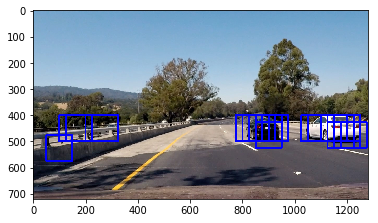

In [86]:
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(100, 100), xy_overlap=(0.75, 0.75))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)          

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

In [87]:
bbox_tag = "bbox_pickle.p"
with open(bbox_tag, 'wb') as f:
    pickle.dump(hot_windows, f)

/Library/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


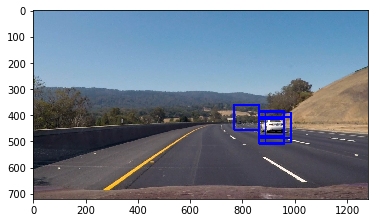

In [27]:
y_start = np.arange(360, 450, 30)
nset = len(y_start) 
window_list = []
for start in y_start:
    y_start_stop = [start, 600]
    window_img, single_list = multiple_window_search(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop)
    window_list.extend(single_list)
    window_img = draw_boxes(draw_image, window_list, color=(0, 0, 255), thick=6)  
plt.imshow(window_img)

/Library/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Test image 06


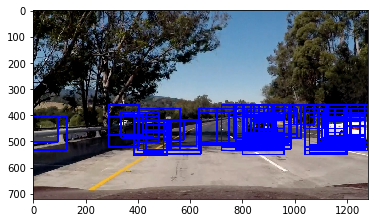

In [95]:
scale_idx = [1.0, 1.2, 1.5, 1.8, 2.0, 2.2, 2.5]
ystart_idx = np.arange(360, 450, 15)
ystop = 600
window_list = []
for scale in scale_idx:
    for ystart in ystart_idx:
        draw_img, single_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        window_list.extend(single_list)
window_img = draw_boxes(draw_image, window_list, color=(0, 0, 255), thick=6)  
plt.imshow(window_img)
print('Test image 06')

In [96]:
# Save the box list
bbox_tag = "bbox_pickle.p"
with open(bbox_tag, 'wb') as f:
    pickle.dump(window_list, f)

### Hog Sub-Sampling Window Search

In [97]:
dist_pickle = pickle.load( open(file_tag, "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
color_space = dist_pickle["color_space"]
hog_channel = dist_pickle["hog_channel"]
spatial_feat = dist_pickle["spatial_feat"]
hist_feat = dist_pickle["hist_feat"]
hog_feat = dist_pickle["hog_feat"]
y_start_stop = dist_pickle["y_start_stop"]

### Multiple Detection and False Positive

In [121]:
# Read in image similar to one shown above 
image = mpimg.imread('test_images/test6.jpg')
image = image.astype(np.float32)/255

In [99]:
bbox_list = pickle.load(open("bbox_pickle.p", "rb" ))

In [100]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, bbox_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 5)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)

draw_img, bbox_saved = draw_labeled_bboxes(np.copy(image), labels)

Test image 05


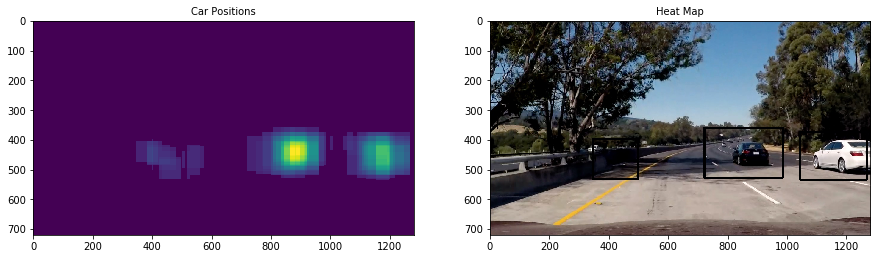

In [101]:
# Visualize 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,30))
ax1.imshow(heatmap)
ax1.set_title('Car Positions', fontsize=10)
ax2.imshow(draw_img)
ax2.set_title('Heat Map', fontsize=10)
print('Test image 05')

### Tracking Pipeline

In [102]:
class Box():
    def __init__(self):
        # Save the box list of the previous clip
        self.count = 0
        self.add_len = []
        self.preframe = []
        self.record = {}

In [117]:
def pipeline(image):
    
    # Duplicate the image
    draw_image = np.copy(image)

    image = image.astype(np.float32)/255
    
    # Load parameters
    dist_pickle = pickle.load(open(file_tag, "rb" ))
    
    # Read in parameters
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    color_space = dist_pickle["color_space"]
    hog_channel = dist_pickle["hog_channel"]
    spatial_feat = dist_pickle["spatial_feat"]
    hist_feat = dist_pickle["hist_feat"]
    hog_feat = dist_pickle["hog_feat"]
    #y_start_stop = dist_pickle["y_start_stop"]
    
    # change the starting point of y
    ystart_idx = np.arange(360, 450, 15) 
    ystop = 600

    # change the scale
    scale_idx = [1.0, 1.2, 1.5, 1.8, 2.0, 2.2, 2.5] 

    window_list = []
    #all_list = []
    for scale in scale_idx:
        for ystart in ystart_idx:
            
            #window_img, single_list = multiple_window_search(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop)
            draw_img, single_list = find_cars(draw_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
            
            #3) Remove multiple detection and false detection
            heat_loop = np.zeros_like(image[:,:,0]).astype(np.float)

            # Add heat to each box in box list
            heat_loop = add_heat(heat_loop, single_list)
            heat_loop = apply_threshold(heat_loop, 1)

            # Visualize the heatmap when displaying    
            heatmap_loop = np.clip(heat_loop, 0, 255)

            # Find final boxes from heatmap using label function
            labels_loop = label(heatmap_loop)
            _, bbox_temp = draw_labeled_bboxes(np.copy(draw_image), labels_loop)
    
            window_list.extend(bbox_temp) 
            #all_list.extend(single_list)
            
    # Track a moving object in the continuous images
    bbox_list = window_list + prelabels.preframe #+ all_list
    
    #3) Remove multiple detection and false detection
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, bbox_list)
    heat = apply_threshold(heat, 13) 

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img, bbox_saved = draw_labeled_bboxes(np.copy(draw_image), labels)

    # Record the boxes in the preivous n frames
    prelabels.count += 1

    if prelabels.count < 15:  
        prelabels.add_len.append(len(bbox_saved))
        prelabels.preframe.extend(bbox_saved)
    else: 
        prelabels.preframe[prelabels.add_len[0]:].extend(bbox_saved)
        prelabels.add_len[1:].append(len(bbox_saved))
        
    prelabels.record[prelabels.count] = bbox_saved
        
    return draw_img

/Library/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Output image 06


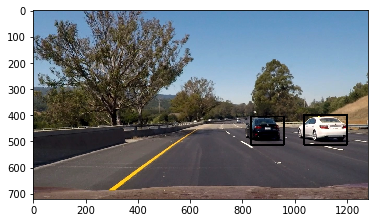

In [122]:
prelabels = Box()
output = pipeline(image)
plt.imshow(output)
print('Output image 06')

In [55]:
# Import packages needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
### pix_per_cell = 16, orient = 12 
prelabels = Box() 
detection_output = 'project_video_test.mp4'
clip = VideoFileClip('project_video.mp4')
video_output = clip.fl_image(pipeline)
%time video_output.write_videofile(detection_output, audio=False)

[MoviePy] >>>> Building video project_video_test.mp4
[MoviePy] Writing video project_video_test.mp4



  8%|▊         | 95/1261 [06:06<1:21:08,  4.17s/it]

In [31]:
saved_record = prelabels
# Save the box list
bbox_set = "bbox_set.p"
with open(bbox_set, 'wb') as f:
    pickle.dump(saved_record.record, f)

In [ ]:
# ===================================================================================

In [66]:
bbox = Box()
def draw_pipe(image):
    
    bbox.count += 1
    
    # Duplicate the image
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255
    
    # Read in the saved tuples of all boxes
    bbox_list = saved_record1.record[bbox.count] + saved_record2.record[bbox.count] 
    
    # Add heat to each box in box list
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)   
    heat = apply_threshold(heat, 2)    
    heatmap = np.clip(heat, 0, 255)
    
    # Visualize the heatmap when displaying  
    labels = label(heatmap)
    draw_img, bbox_saved = draw_labeled_bboxes(np.copy(draw_image), labels)
    
    return draw_img

In [67]:
detection_output = 'project_video_final.mp4'
clip = VideoFileClip('project_video.mp4')
video_output = clip.fl_image(draw_pipe)
%time video_output.write_videofile(detection_output, audio=False)

[MoviePy] >>>> Building video project_video_output_final_.mp4
[MoviePy] Writing video project_video_output_final_.mp4



 71%|███████   | 890/1261 [00:40<00:16, 21.90it/s]


100%|█████████▉| 1260/1261 [00:57<00:00, 21.95it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_final_.mp4 

CPU times: user 23.2 s, sys: 12.7 s, total: 35.9 s
Wall time: 58.5 s
